<a href="https://colab.research.google.com/github/ToanToan110/CustomerLifeTimeValue/blob/main/CustomerLifeTimeValue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Overview***
**Customer Life Time Value (CLV):** Giá trị mà khách hàng mang lại trong suốt khoảng thời gian họ hoạt động.
Xác định đâu là đối tượng khách hàng đáng để đầu tư và khai thác.

Doanh nghiệp cần tính toán được chỉ số CLV để xác định được đâu là nhóm khách hàng mang lại giá trị cao.

=> Đưa ra các chiến lược tiếp thị phù hợp để tối ưu hóa lợi nhuận và chi phí bỏ ra
# ***Nội dung notebook***
 - Output: xác định đâu là nhóm khách hàng mang lại giá trị (CLV cao)
 - Đưa ra các kĩ thuật xác định và phân nhóm CLV, lựa chọn mô hình máy học phù hợp để phân loại nhóm high-CLV.

# I. Chuẩn bị dữ liệu:

In [1]:
import pandas as pd
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import timedelta

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/OnlineRetail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Clean data

In [8]:
tx_data = df.copy()
tx_data.dropna(subset='CustomerID', inplace = True)
tx_data['Revenue'] = tx_data['Quantity']*tx_data['UnitPrice']
tx_data['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk = tx_uk[tx_uk['UnitPrice'] >= 0]
tx_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361878 entries, 0 to 361877
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
 8   Revenue      361878 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 24.8+ MB


## Convert to RFM data:

In [9]:
def GetRFM(tx_uk):
  tx_user = pd.DataFrame(tx_uk['CustomerID'].unique())
  tx_user.columns = ['CustomerID']

  #calculate recency score
  tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
  tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
  tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
  tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

  #calcuate frequency score
  tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
  tx_frequency.columns = ['CustomerID','Frequency']
  tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

  #calcuate revenue score
  tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
  tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()
  tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

  return tx_user
df_rfm = GetRFM(tx_uk)
df_rfm.head()

,CustomerID,Recency,Frequency,Revenue
0,17850.0,301,312,5288.63
1,13047.0,31,196,3079.10
2,13748.0,95,28,948.25
3,15100.0,329,6,635.10
4,15291.0,25,109,4596.51


## Tính toán Customer Life time value
**Đến Công thức tính toán CLV:**



          CLTV = (Customer Value / Churn Rate) × Profit Margin


Trong đó:
- CLTV = (Customer Value / Churn Rate) × Profit Margin
- Customer Value = Average Order Value * Purchase Frequency
- Average Order Value = Total Price / Total Transaction
- Purchase Frequency = Total Transaction / Total Number of Customers
- Churn Rate = 1 - Repeat Rate
- Repeat Rate = The rate of customers who have made multiple purchases divided by the total number of customers.
- Profit Margin = Total Price * 0.10
---




In [10]:
cltv_c = tx_uk.groupby('CustomerID').agg({'CustomerID': lambda CustomerID: CustomerID.value_counts(),
                                        'Quantity': lambda x: x.sum(),
                                        'Revenue': lambda x: x.sum()})

cltv_c.columns = ['Total Transaction', 'Total Unit', 'Total Price']
cltv_c.head()

,Total Transaction,Total Unit,Total Price
CustomerID,,,
12346.0,2,0,0.00
12747.0,103,1275,4196.01
12748.0,4642,24210,29072.10
12749.0,231,1422,3868.20
12820.0,59,722,942.34


In [11]:
cltv_c["Average Order Value"] = cltv_c["Total Price"].sum() / cltv_c["Total Transaction"].sum()
cltv_c["Purchase Frequency"] = cltv_c["Total Transaction"] / cltv_c.shape[0]
cltv_c['Profit Margin'] = cltv_c['Total Price'] * 0.10
repeat_rate = cltv_c[cltv_c["Total Transaction"] > 1].shape[0] / cltv_c.shape[0]

churn_rate = 1 - repeat_rate
cltv_c['Customer Value'] = cltv_c['Average Order Value'] * cltv_c["Purchase Frequency"]
cltv_c["CLV"] = (cltv_c["Customer Value"] / churn_rate) * cltv_c["Profit Margin"]

cltv_c.reset_index(inplace = True)
cltv_c.sort_values(by="CLV", ascending=False).head()

,CustomerID,Total Transaction,Total Unit,Total Price,Average Order Value,Purchase Frequency,Profit Margin,Customer Value,CLV
3621,17841.0,7983,22865,40340.78,18.702086,2.021013,4034.078,37.797152,7.924774e+06
909,14096.0,5128,16335,57120.91,18.702086,1.298228,5712.091,24.279569,7.208080e+06
1783,15311.0,2491,37720,59419.34,18.702086,0.630633,5941.934,11.794151,3.642319e+06
2,12748.0,4642,24210,29072.10,18.702086,1.175190,2907.210,21.978502,3.320917e+06
3811,18102.0,433,64122,256438.49,18.702086,0.109620,25643.849,2.050127,2.732421e+06


In [30]:
df_train = df_rfm.merge(cltv_c, on = 'CustomerID', how ='inner')
df_train.describe()

,CustomerID,Recency,Frequency,Revenue,Total Transaction,Total Unit,Total Price,Average Order Value,Purchase Frequency,Profit Margin,Customer Value,CLV
count,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3.950000e+03,3950.000000,3950.000000,3950.000000,3.950000e+03
mean,15562.029367,90.778481,91.614684,1713.385669,91.614684,1014.818481,1713.385669,1.870209e+01,0.023194,171.338567,0.433769,1.687193e+04
std,1576.848325,100.230349,220.557389,6548.608224,220.557389,3198.469949,6548.608224,3.553163e-15,0.055837,654.860822,1.044274,2.080882e+05
min,12346.000000,0.000000,1.000000,-4287.630000,1.000000,-303.000000,-4287.630000,1.870209e+01,0.000253,-428.763000,0.004735,-4.301357e+02
25%,14208.250000,16.000000,17.000000,282.255000,17.000000,147.000000,282.255000,1.870209e+01,0.004304,28.225500,0.080490,1.225971e+02
50%,15571.500000,49.000000,41.000000,627.060000,41.000000,355.000000,627.060000,1.870209e+01,0.010380,62.706000,0.194123,6.034603e+02
75%,16913.750000,142.000000,101.000000,1521.782500,101.000000,928.750000,1521.782500,1.870209e+01,0.025570,152.178250,0.478205,3.471827e+03
max,18287.000000,373.000000,7983.000000,256438.490000,7983.000000,69029.000000,256438.490000,1.870209e+01,2.021013,25643.849000,37.797152,7.924774e+06


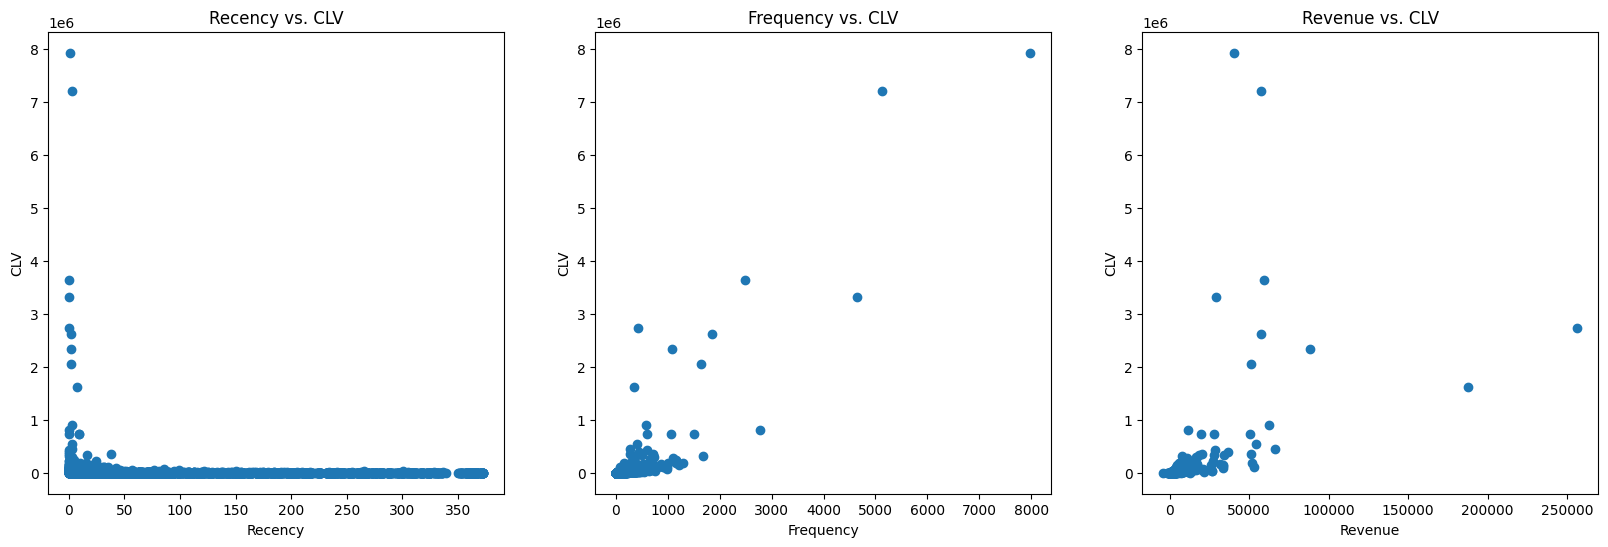

In [13]:
# @title EDA
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(['Recency', 'Frequency', 'Revenue']):
  axes[i].scatter(df_train[col], df_train['CLV'])
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('CLV')
  axes[i].set_title(f'{col} vs. CLV')

In [44]:
# def outlier_thresholds(df_diabetes, variable):
#     # IQR
#     # Calculate the upper and lower limits
#     Q1 = df_diabetes[variable].quantile(0.05)
#     Q3 = df_diabetes[variable].quantile(0.95)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5*IQR
#     upper = Q3 + 1.5*IQR
#     # Removing the outliers
#     df_diabetes = df_diabetes[df_diabetes[variable] <= upper]
#     df_diabetes = df_diabetes[df_diabetes[variable] >= lower]
#     return df_diabetes

# df_train = outlier_thresholds(df_train, "Recency")
# df_train = outlier_thresholds(df_train, "Frequency")
# df_train = outlier_thresholds(df_train, "Revenue")
# df_train.shape
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_std = df_train[['Recency', 'Frequency', 'Revenue']]
df_std = scaler.fit_transform(df_std)
df_std = pd.DataFrame(df_std, columns =['Recency', 'Frequency', 'Revenue'])

## II.3. Đào tạo mô hình theo hướng 2:

In [49]:
#import machine learning related libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
x = df_std[['Recency', 'Frequency', 'Revenue']]
y = df_train[['CLV']]
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [46]:
y_train2 = np.ravel(y_train2)
y_test2 = np.ravel(y_test2)
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(2765, 3)
(1185, 3)
(2765,)
(1185,)


In [56]:
# Instantiate the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5),
    "Support Vector Regression (SVR)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "XGBoost Regression": xgb.XGBRegressor(objective='reg:squarederror'),
    "K-Nearest Neighbors Regression": KNeighborsRegressor(n_neighbors=5)
}

# Training and evaluating the models
report = pd.DataFrame()
results = {}
for name, model in models.items():
    model.fit(x_train2, y_train2)  # Some models require a 1D array for y
    y_pred = model.predict(x_test2)
    mse = mean_squared_error(y_test2, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test2, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "R-squared": r2}
report = pd.DataFrame(results)
report

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,Support Vector Regression (SVR),Decision Tree Regression,Random Forest Regression,Gradient Boosting Regression,XGBoost Regression,K-Nearest Neighbors Regression
MSE,8.221372e+09,8.215459e+09,8.221382e+09,5.315053e+09,2.204031e+10,3.088718e+10,6.585124e+09,1.826261e+10,8.549668e+10,3.844971e+09
RMSE,9.067178e+04,9.063917e+04,9.067184e+04,7.290441e+04,1.484598e+05,1.757475e+05,8.114878e+04,1.351392e+05,2.923981e+05,6.200783e+04
R-squared,6.271810e-01,6.274491e-01,6.271805e-01,7.589754e-01,5.259834e-04,-4.006578e-01,7.013808e-01,1.718353e-01,-2.877064e+00,8.256400e-01


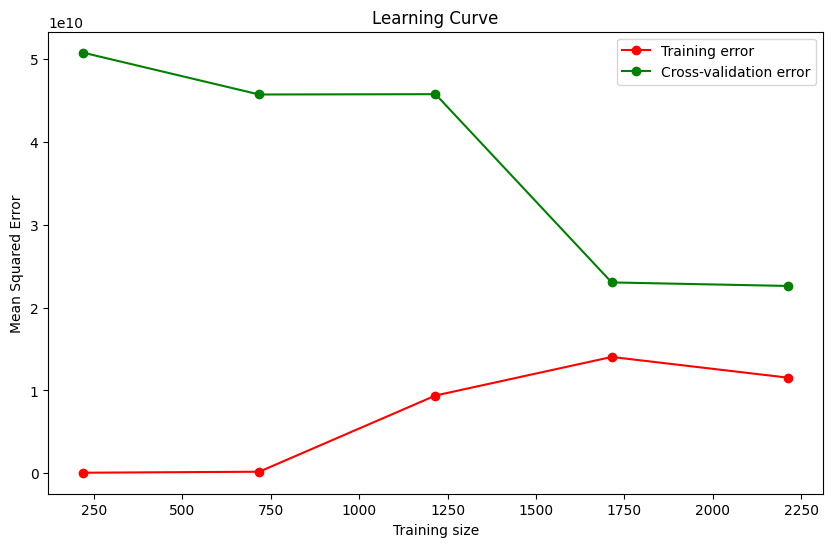

In [57]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(KNeighborsRegressor(n_neighbors=5), x_train2, y_train2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()